In [42]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from IPython.display import display
import warnings

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

import scipy.stats as stats
import scipy
import scipy.stats.stats
from scipy.stats import poisson

import scipy.stats
import phik

In [43]:
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 20)
pd.options.display.float_format = '{:,.2f}'.format

import warnings

# Подавление предупреждений SettingWithCopyWarning
warnings.filterwarnings('ignore', category=UserWarning, message='SettingWithCopyWarning')

### Функции

In [44]:
# функция информации по таблице
def dataframe_summary(df, string):
    # Вывод общей информации
    print("Общая информация по таблице:", string)
    df.info()

    # Вывод статистического описания
    print("\n Статистическое описание:")
    display(df.describe().transpose())

    # Вывод случайных примеров
    print("\nСлучайные примеры:")
    display(df.sample(5))

    # Вывод количества строк и столбцов
    print("\nКоличество строк и столбцов:", df.shape)
    
    # Вывод количества явных дубликатов
    print("\nКоличество явных дубликатов:", df.duplicated().sum())
    print('')

In [45]:
# функция поиска пропусков
def analyze_missing_values(dataframes, names):
    for i, df in enumerate(dataframes):
        # Подсчет количества и процента пропущенных значений
        total = df.isnull().sum().sort_values(ascending=False)
        percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        missing_data = missing_data.query('Total > 0')

        # Вывод информации о пропусках
        print(f"Пропуски в датафрейме {names[i]}:\n{missing_data}\n")

        # Создание и отображение тепловой карты
        plt.figure(figsize=(12, 8))
        sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
        plt.title(f"Heatmap пропусков для {names[i]}")
        plt.show()

In [46]:
# функция описательной статистики числового признака
def descriptive_stats_and_plot(df, numeric_column):
    if numeric_column not in df.columns:
        print(f"Столбец '{numeric_column}' не найден в DataFrame.")
        return

    # Описательная статистика
    descriptive_stats = df.groupby('music_genre')[numeric_column].describe()
    display(f"Описательная статистика для {numeric_column}:", descriptive_stats)

    # Визуализация распределения
    plt.figure(figsize=(12, 15))
    sns.violinplot(x=numeric_column, y='music_genre',hue="music_genre" ,data=df, split=True, inner='quart')

    # Расчет общей медианы и среднего
    overall_median = df[numeric_column].median()
    overall_mean = df[numeric_column].mean()

    # Добавление линий медианы и среднего
    plt.axvline(overall_median, color='blue', linestyle='--', alpha=0.7, linewidth=2.5, label=f'Медиана: {overall_median:.2f}')
    plt.axvline(overall_mean, color='red', linestyle='--', alpha=0.7, linewidth=2.5, label=f'Среднее: {overall_mean:.2f}')

    plt.title(f'Распределение {numeric_column} по жанрам музыки')
    plt.legend()
    
    plt.figure(figsize=(12, 15))
    sns.boxplot(x=numeric_column, y='music_genre',hue="music_genre", data=df)

    # Расчет общей медианы и среднего
    overall_median = df[numeric_column].median()
    overall_mean = df[numeric_column].mean()

    # Добавление линий медианы и среднего
    plt.axvline(overall_median, color='blue', linestyle='--', alpha=0.7, linewidth=2.5, label=f'Медиана: {overall_median:.2f}')
    plt.axvline(overall_mean, color='red', linestyle='--', alpha=0.7, linewidth=2.5, label=f'Среднее: {overall_mean:.2f}')

    plt.title(f'Распределение {numeric_column} по жанрам музыки')
    plt.legend()
    plt.show()

In [47]:
def fill_na_with_genre_median(df, numeric_column):
    # Вычисление медианы для каждого жанра
    median_per_genre = df.groupby('music_genre')[numeric_column].median()

    # Функция для заполнения пропусков
    def fill_na(row):
        if pd.isna(row[numeric_column]):
            return median_per_genre[row['music_genre']]
        else:
            return row[numeric_column]

    # Применение функции к каждой строке
    df[numeric_column] = df.apply(fill_na, axis=1)

In [48]:
def fill_na_with_quantile(df, numeric_column):
    # Вычисление 25-го и 75-го квартилей для указанной числовой переменной по каждому жанру
    quantile_table = df.groupby('music_genre')[numeric_column].quantile([0.25, 0.75]).unstack()

    # Переименование колонок
    quantile_table.columns = ['percentile_25', 'percentile_75']

    # Сброс индекса, чтобы 'music_genre' стал колонкой
    quantile_table.reset_index(inplace=True)

    # Объединение с исходным DataFrame
    merged = df.merge(quantile_table, on='music_genre', how='left')

    # Функция для заполнения пропусков
    def fill_na(row):
        if pd.isna(row[numeric_column]):
            return np.random.uniform(row['percentile_25'], row['percentile_75'])
        else:
            return row[numeric_column]

    # Применение функции к каждой строке
    df[numeric_column] = merged.apply(fill_na, axis=1)

In [49]:
# Функция для заполнения пропущенных значений key
def fill_missing_keys(row):
    if pd.isna(row['key']):
        return np.random.choice(top_keys_per_genre[row['music_genre']])
    else:
        return row['key']

In [50]:
def replace_question_marks_with_random(df, column):
    # Преобразование столбца в числовой тип, замена '?' на NaN
    df[column] = pd.to_numeric(df[column], errors='coerce')

    # Вычисление Q1 и Q3 квартилей для указанной переменной по каждому жанру
    quantile_table = df.groupby('music_genre')[column].quantile([0.25, 0.75]).unstack()
    quantile_table.columns = ['Q1', 'Q3']

    # Функция для замены NaN на случайное значение между Q1 и Q3
    def replace_with_random(row):
        if pd.isna(row[column]):
            lower_bound = quantile_table.loc[row['music_genre'], 'Q1']
            upper_bound = quantile_table.loc[row['music_genre'], 'Q3']
            return np.random.uniform(lower_bound, upper_bound)
        else:
            return row[column]

    # Применение функции к каждой строке
    df[column] = df.apply(replace_with_random, axis=1)
    return df

In [51]:
def fill_na_most_frequent_per_genre(df, column, target_column='music_genre'):
    # Вычисление самого частого значения для каждого жанра
    mode_per_genre = df.groupby(target_column)[column].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

    # Функция для заполнения пропусков
    def fill_na(row):
        if pd.isna(row[column]):
            return mode_per_genre[row[target_column]]
        else:
            return row[column]

    # Применение функции к каждой строке
    df[column] = df.apply(fill_na, axis=1)

In [52]:
def categorical_analysis(df, category_column, target_column='music_genre'):
    # Статистическая информация
    stats = df.groupby(target_column)[category_column].value_counts(normalize=True).unstack().fillna(0)
    
    # Графическая информация
    plt.figure(figsize=(12, 6))
    sns.countplot(x=category_column, hue=target_column, data=df)
    plt.title(f'Distribution of {category_column} within {target_column}')
    plt.xticks(rotation=45)
    plt.show()
    
    return stats

In [53]:
file_names = {
    'train': 'train.csv',
    'test': 'test.csv'
}

# Загрузка каждого файла в соответствующую переменную
for variable, file_name in file_names.items():
    globals()[variable] = pd.read_csv(file_name)

file_names = list(file_names.keys())

In [54]:
train = train
test = test
dataframes = [train , test]
# Размер до удаления данных в train
initial_size = train.shape[0]

In [55]:
sorted_df = train.sort_values(by='instance_id')

# Находим границы изменения жанра
sorted_df['genre_shift'] = sorted_df['music_genre'].ne(sorted_df['music_genre'].shift()).cumsum()

# Получаем первый instance_id для каждого жанра
genre_bounds = sorted_df.drop_duplicates(subset='genre_shift', keep='first')[['instance_id', 'music_genre']]

print(genre_bounds)

       instance_id  music_genre
6836          1000   Electronic
9755          6000        Anime
6578         11001         Jazz
13225        16000  Alternative
31546        21000      Country
6730         26000          Rap
21280        31000        Blues
17389        36000         Rock
27682        41000    Classical
4057         46002      Hip-Hop


In [56]:
# Функция для определения жанра на основе instance_id
def assign_genre(instance_id):
    for i in range(len(genre_bounds) - 1):
        # Проверка в каком диапазоне находится instance_id
        if genre_bounds.iloc[i]['instance_id'] <= instance_id < genre_bounds.iloc[i+1]['instance_id']:
            return genre_bounds.iloc[i]['music_genre']
    # Для instance_id, которые больше последнего в genre_bounds, возвращаем последний жанр
    return genre_bounds.iloc[-1]['music_genre']

# Применение функции к тестовому набору данных
test['music_genre'] = test['instance_id'].apply(assign_genre)

# Вывод первых нескольких строк тестового набора данных для проверки
print(test[['instance_id', 'music_genre']].head())

   instance_id  music_genre
0        20514  Alternative
1        46957      Hip-Hop
2         5488   Electronic
3        18150  Alternative
4        20148  Alternative


In [57]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       10000 non-null  int64  
 1   track_name        7388 non-null   object 
 2   popularity        8987 non-null   float64
 3   acousticness      10000 non-null  float64
 4   danceability      9477 non-null   float64
 5   duration_ms       10000 non-null  float64
 6   energy            10000 non-null  float64
 7   instrumentalness  10000 non-null  float64
 8   key               9673 non-null   object 
 9   liveness          10000 non-null  float64
 10  loudness          10000 non-null  float64
 11  mode              9518 non-null   object 
 12  speechiness       10000 non-null  float64
 13  tempo             10000 non-null  object 
 14  obtained_date     8419 non-null   object 
 15  valence           10000 non-null  float64
 16  music_genre       10000 non-null  object 

In [58]:
# Используем функцию заполнения пропусков медианой
fill_na_with_genre_median(test, 'popularity')

In [59]:
fill_na_with_quantile(test, 'danceability')

print(f'Пропусков в столбце danceability: {test["danceability"].isnull().sum()}')

Пропусков в столбце danceability: 0


In [60]:
top_keys_per_genre = test.groupby('music_genre')['key'].apply(lambda x: x.value_counts().head(3).index.tolist())

test['key'] = test.apply(fill_missing_keys, axis=1)

In [61]:
fill_na_most_frequent_per_genre(test, 'mode')

C:\Users\42\AppData\Local\Temp\ipykernel_14060\1526610998.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = test[train['music_genre'] == genre]
C:\Users\42\AppData\Local\Temp\ipykernel_14060\1526610998.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = test[train['music_genre'] == genre]
C:\Users\42\AppData\Local\Temp\ipykernel_14060\1526610998.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = test[train['music_genre'] == genre]
C:\Users\42\AppData\Local\Temp\ipykernel_14060\1526610998.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = test[train['music_genre'] == genre]
C:\Users\42\AppData\Local\Temp\ipykernel_14060\1526610998.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = test[train['music_genre'] == genre]
C:\Users\42\AppData\Local\Temp\ipykernel_14060\1526610998.py:4: U

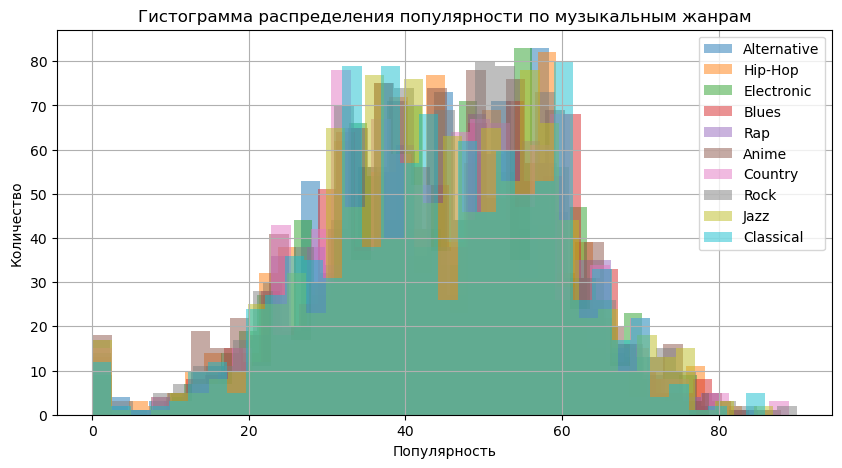

'Описательная статистика для popularity:'

,count,mean,std,min,25%,50%,75%,max
music_genre,,,,,,,,
Alternative,"3,572.00",50.37,7.54,0.00,45.00,49.00,55.00,83.00
Anime,"3,630.00",24.19,9.63,0.00,17.00,23.00,30.00,65.00
Blues,"3,599.00",34.84,9.65,0.00,29.00,33.00,39.00,74.00
Classical,"3,616.00",29.40,14.10,0.00,25.00,32.00,38.00,68.00
Country,"3,593.00",46.01,9.80,0.00,39.00,44.00,51.00,82.00
Electronic,"3,679.00",38.11,9.72,0.00,31.00,37.00,44.00,96.00
Hip-Hop,"3,540.00",58.36,8.32,19.00,52.00,57.00,63.00,96.00
Jazz,"3,629.00",40.94,9.57,0.00,36.00,40.00,46.00,79.00
Rap,"3,578.00",60.58,8.22,14.00,55.00,59.00,65.00,99.00


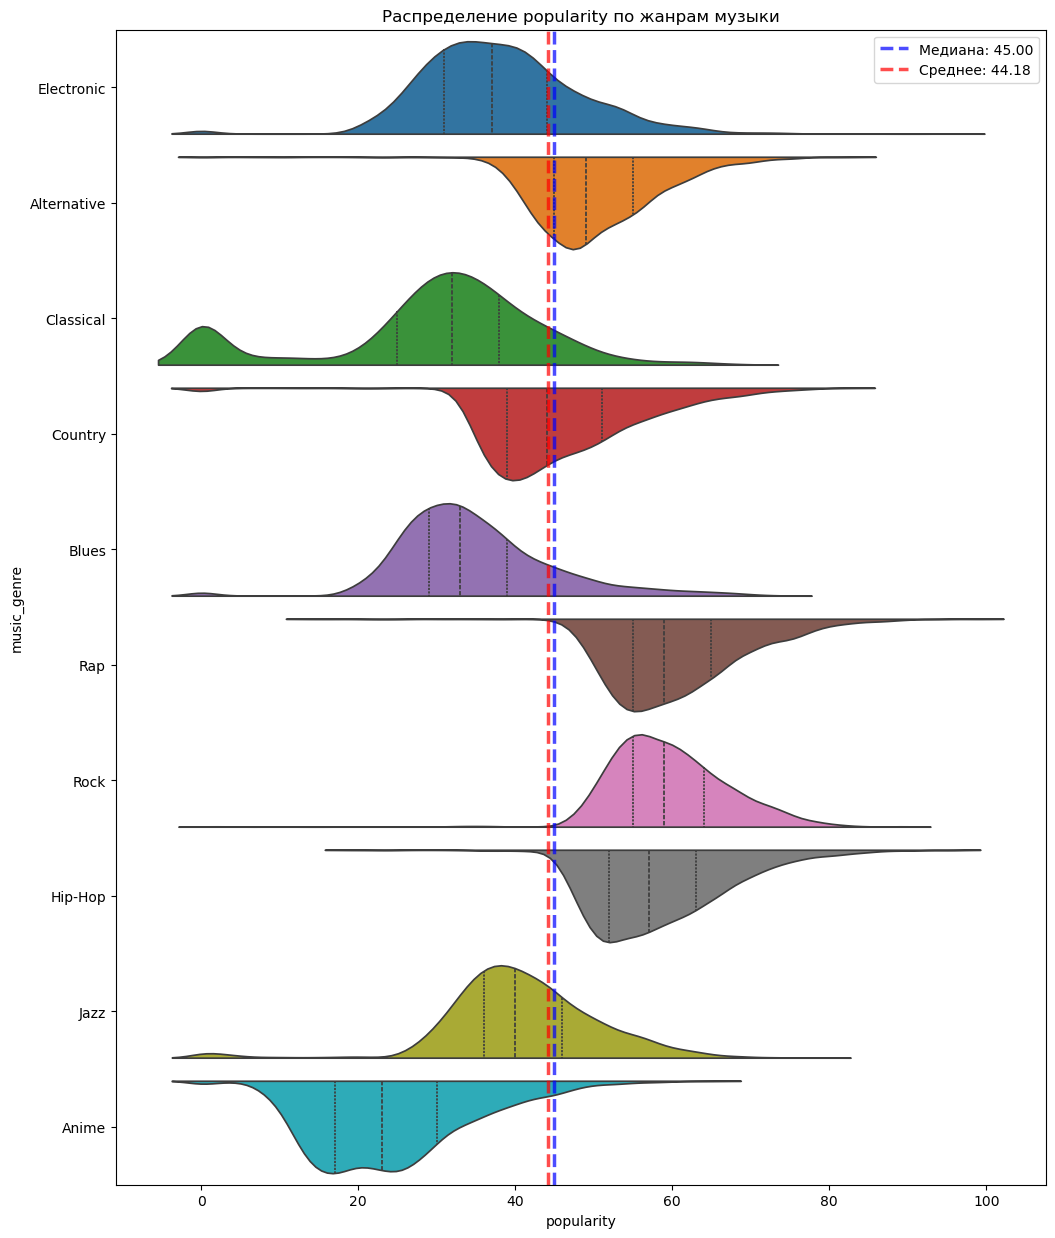

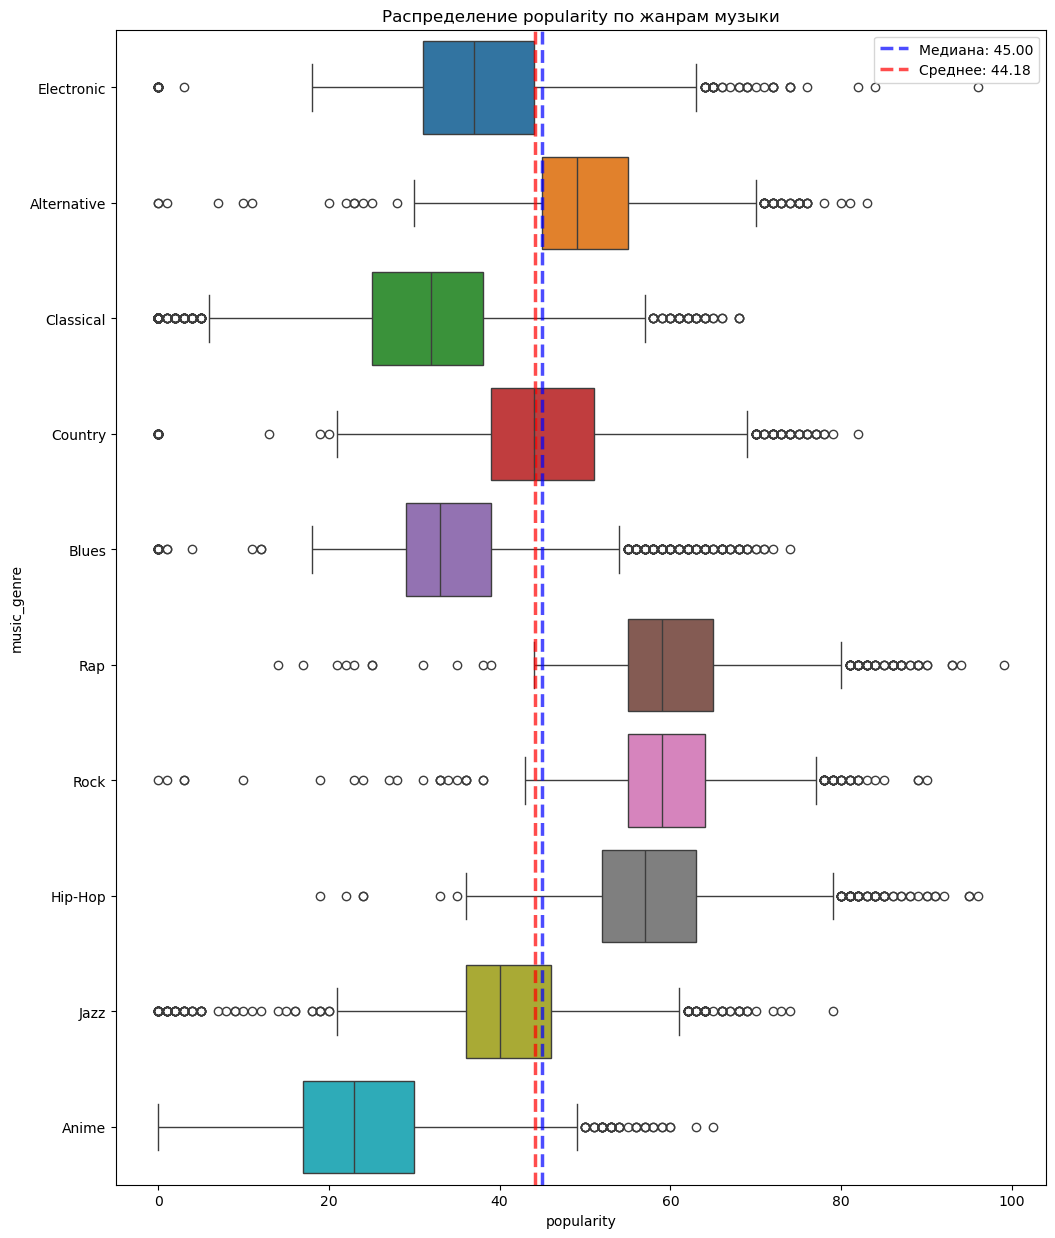

In [64]:
genres = test['music_genre'].unique()   
plt.figure(figsize=(10, 5))
for genre in genres:
    subset = test[train['music_genre'] == genre]
    plt.hist(subset['popularity'], bins=35, label=genre, alpha=0.5)
plt.title('Гистограмма распределения популярности по музыкальным жанрам')
plt.xlabel('Популярность')
plt.ylabel('Количество')
plt.legend()
plt.grid(True)
plt.show()
descriptive_stats_and_plot(train, 'popularity')

'Описательная статистика для acousticness:'

,count,mean,std,min,25%,50%,75%,max
music_genre,,,,,,,,
Alternative,"1,061.00",0.17,0.24,0.00,0.00,0.04,0.25,0.99
Anime,998.00,0.26,0.35,0.00,0.00,0.06,0.48,1.00
Blues,"1,013.00",0.31,0.30,0.00,0.03,0.19,0.55,1.00
Classical,983.00,0.87,0.26,0.00,0.91,0.97,0.99,1.00
Country,976.00,0.26,0.26,0.00,0.04,0.17,0.43,0.96
Electronic,949.00,0.13,0.21,0.00,0.00,0.03,0.15,0.98
Hip-Hop,"1,063.00",0.18,0.18,0.00,0.04,0.11,0.26,0.94
Jazz,976.00,0.50,0.34,0.00,0.17,0.54,0.82,1.00
Rap,"1,036.00",0.17,0.20,0.00,0.02,0.10,0.25,0.94


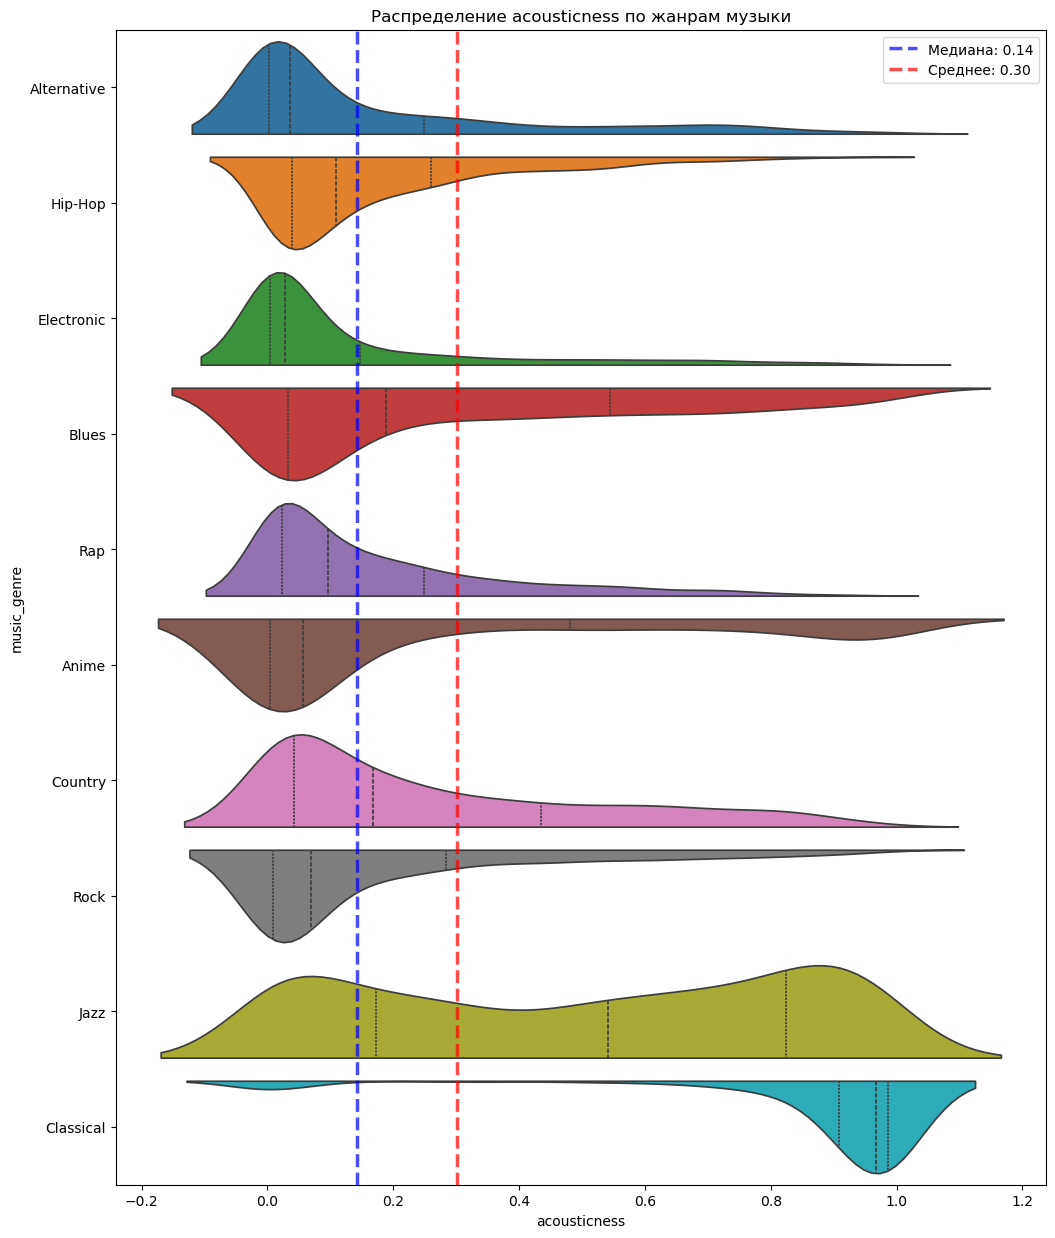

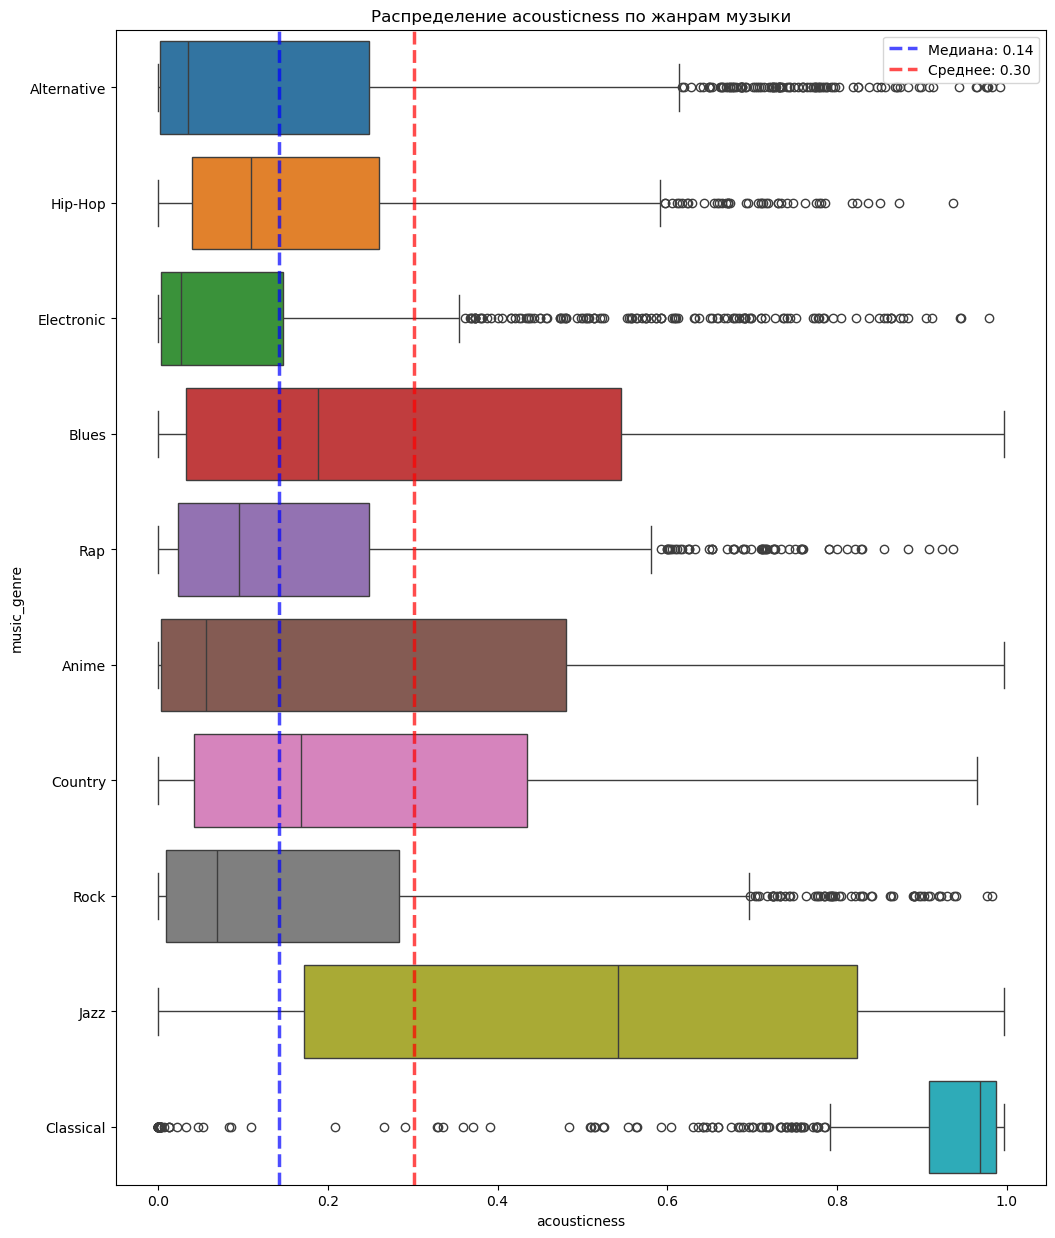

In [65]:
descriptive_stats_and_plot(test, 'acousticness')

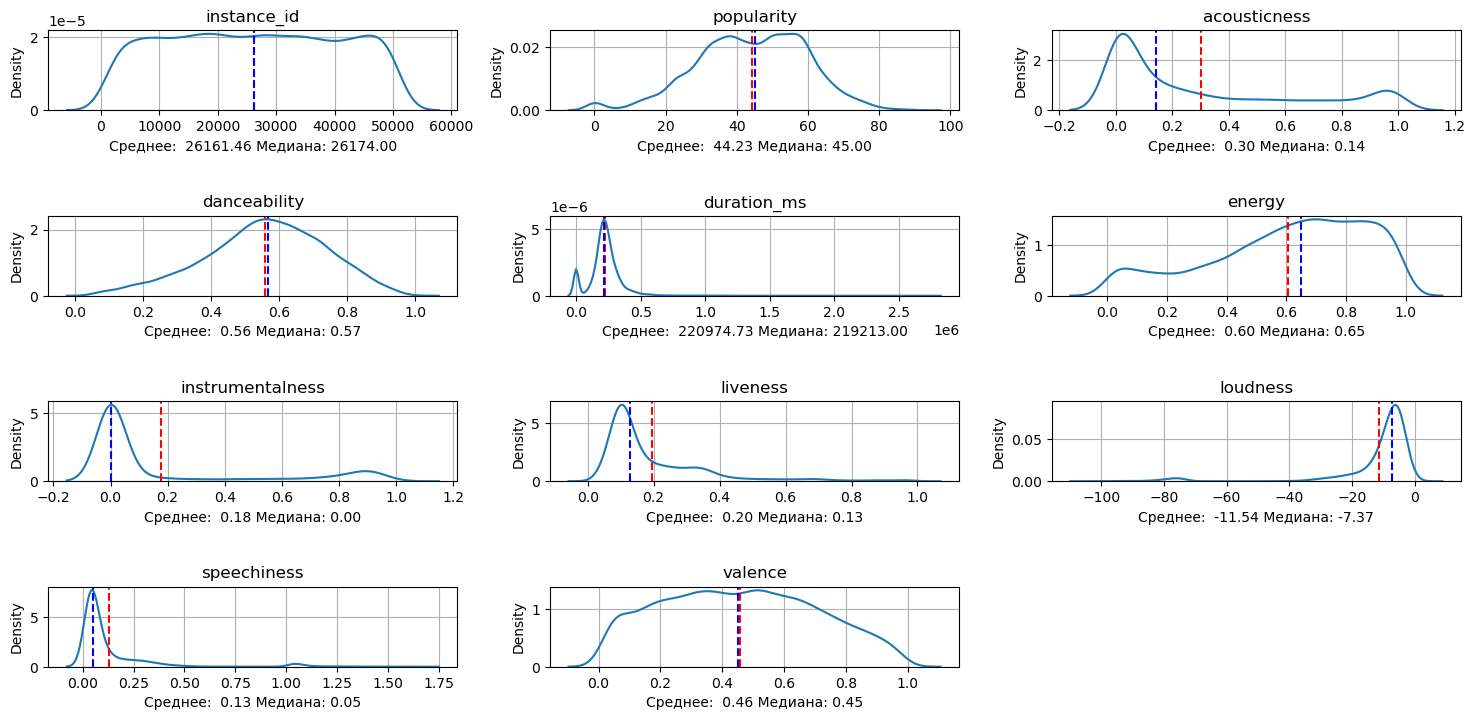

In [66]:
fig = plt.figure(figsize=(15, 18))
# Выбираем только числовые данные
df_dist = test.select_dtypes([int, float]) 


for i, column in enumerate(df_dist.columns, 1):
        ax = plt.subplot(10, 3, i) 
        sns.kdeplot(x=df_dist[column], ax=ax)
        ax.set_title(column)
        ax.grid(True)  # Добавление сетки

        # Добавление линии среднего значения
        mean_value = df_dist[column].mean()
        ax.axvline(mean_value, color='r', linestyle='--')
        ax.set_xlabel(f'Среднее:')
        
        # Добавление линии медианного значения
        median_value = df_dist[column].median()
        ax.axvline(median_value, color='b', linestyle='--')

        ax.set_xlabel(f'Среднее:  {mean_value:.2f} Медиана: {median_value:.2f}')
        
plt.tight_layout(h_pad=3)
plt.show()